In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
data_path = "/kaggle/input/manipal-atmospherics/manipal_atmospherics_df.csv"

df = pd.read_csv(
    data_path,
    skiprows=2   # <-- CRITICAL FIX
)

print("Shape:", df.shape)
df.head()


Shape: (5480, 13)


,time,temperature_2m_mean (°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/m²),apparent_temperature_mean (°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (°C),soil_moisture_0_to_7cm_mean (m³/m³)
0,2011-01-04,24.7,0.0,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278
1,2011-01-05,25.4,0.0,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276
2,2011-01-06,26.2,0.0,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273
3,2011-01-07,25.6,0.0,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270
4,2011-01-08,25.2,0.0,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268


In [3]:
# Rename columns to ML-friendly names
df = df.rename(columns={
    'time': 'date',
    'temperature_2m_mean (°C)': 'temperature_2m_mean',
    'precipitation_sum (mm)': 'precipitation_sum',
    'shortwave_radiation_sum (MJ/m²)': 'shortwave_radiation_sum',
    'apparent_temperature_mean (°C)': 'apparent_temperature_mean',
    'wind_speed_10m_max (km/h)': 'wind_speed_10m_max',
    'et0_fao_evapotranspiration (mm)': 'et0_fao_evapotranspiration',
    'sunshine_duration (s)': 'sunshine_duration',
    'wind_direction_10m_dominant (°)': 'wind_direction_10m_dominant',
    'pressure_msl_mean (hPa)': 'pressure_msl_mean',
    'cloud_cover_mean (%)': 'cloud_cover_mean',
    'dew_point_2m_mean (°C)': 'dew_point_2m_mean',
    'soil_moisture_0_to_7cm_mean (m³/m³)': 'soil_moisture_0_to_7cm_mean'
})

# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Sort chronologically
df = df.sort_values('date').reset_index(drop=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5480 entries, 0 to 5479
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         5480 non-null   datetime64[ns]
 1   temperature_2m_mean          5480 non-null   float64       
 2   precipitation_sum            5480 non-null   float64       
 3   shortwave_radiation_sum      5480 non-null   float64       
 4   apparent_temperature_mean    5480 non-null   float64       
 5   wind_speed_10m_max           5480 non-null   float64       
 6   et0_fao_evapotranspiration   5480 non-null   float64       
 7   sunshine_duration            5480 non-null   float64       
 8   wind_direction_10m_dominant  5480 non-null   int64         
 9   pressure_msl_mean            5480 non-null   float64       
 10  cloud_cover_mean             5480 non-null   int64         
 11  dew_point_2m_mean            5480 non-null 

In [4]:
df.isna().sum()
# Forward fill (safe for time-series)
df = df.fillna(method='ffill')


In [5]:
train_df = df[df['date'] < '2023-01-01']
val_df   = df[(df['date'] >= '2023-01-01') & (df['date'] < '2025-01-04')]
test_df  = df[(df['date'] >= '2025-01-04') & (df['date'] <= '2026-01-04')]

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Train: 4380
Validation: 734
Test: 366


In [6]:
features = [
    'temperature_2m_mean',
    'precipitation_sum',
    'shortwave_radiation_sum',
    'apparent_temperature_mean',
    'wind_speed_10m_max',
    'et0_fao_evapotranspiration',
    'sunshine_duration',
    'pressure_msl_mean',
    'cloud_cover_mean',
    'dew_point_2m_mean',
    'soil_moisture_0_to_7cm_mean'
]

target_temp = 'temperature_2m_mean'
target_prec = 'precipitation_sum'

scaler = StandardScaler()
scaler.fit(train_df[features])

train_scaled = scaler.transform(train_df[features])
val_scaled   = scaler.transform(val_df[features])
test_scaled  = scaler.transform(test_df[features])


In [7]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, target_idx, window=30):
        self.X, self.y = [], []
        for i in range(len(data) - window):
            self.X.append(data[i:i+window])
            self.y.append(data[i+window, target_idx])

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [8]:
WINDOW = 30
BATCH_SIZE = 32

temp_idx = features.index(target_temp)
prec_idx = features.index(target_prec)

train_ds_temp = TimeSeriesDataset(train_scaled, temp_idx, WINDOW)
val_ds_temp   = TimeSeriesDataset(val_scaled, temp_idx, WINDOW)
test_ds_temp  = TimeSeriesDataset(test_scaled, temp_idx, WINDOW)

train_loader = DataLoader(train_ds_temp, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds_temp, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])


In [10]:
def train_model(model, train_loader, val_loader, epochs=25):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        tl = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X).squeeze(), y)
            loss.backward()
            optimizer.step()
            tl += loss.item()

        model.eval()
        vl = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                vl += loss_fn(model(X).squeeze(), y).item()

        train_losses.append(tl / len(train_loader))
        val_losses.append(vl / len(val_loader))

        print(f"Epoch {epoch+1}: Train {train_losses[-1]:.4f}, Val {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [11]:
model_temp = LSTMModel(len(features))
train_losses, val_losses = train_model(model_temp, train_loader, val_loader)


Epoch 1: Train 0.2660, Val 0.1507
Epoch 2: Train 0.1389, Val 0.1414
Epoch 3: Train 0.1203, Val 0.1119
Epoch 4: Train 0.1110, Val 0.1088
Epoch 5: Train 0.1060, Val 0.1112
Epoch 6: Train 0.1024, Val 0.1057
Epoch 7: Train 0.1015, Val 0.1088
Epoch 8: Train 0.1002, Val 0.1041
Epoch 9: Train 0.0992, Val 0.1039
Epoch 10: Train 0.0993, Val 0.1069
Epoch 11: Train 0.0976, Val 0.1035
Epoch 12: Train 0.0974, Val 0.1056
Epoch 13: Train 0.0966, Val 0.1024
Epoch 14: Train 0.0961, Val 0.1017
Epoch 15: Train 0.0948, Val 0.1026
Epoch 16: Train 0.0951, Val 0.0997
Epoch 17: Train 0.0936, Val 0.1011
Epoch 18: Train 0.0937, Val 0.1043
Epoch 19: Train 0.0930, Val 0.1025
Epoch 20: Train 0.0918, Val 0.1026
Epoch 21: Train 0.0912, Val 0.1075
Epoch 22: Train 0.0899, Val 0.1086
Epoch 23: Train 0.0885, Val 0.1035
Epoch 24: Train 0.0875, Val 0.1033
Epoch 25: Train 0.0865, Val 0.1148


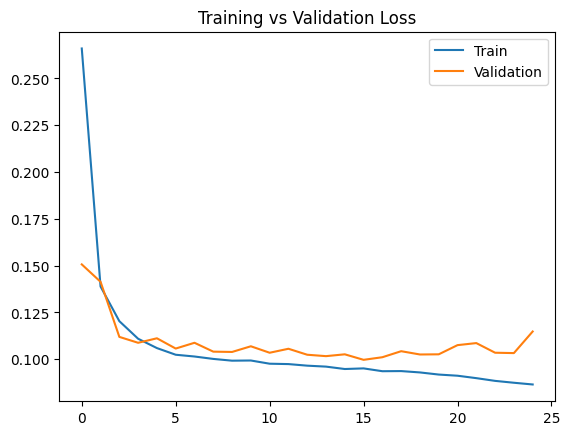

In [12]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [13]:
model_temp.eval()
preds, actuals = [], []

with torch.no_grad():
    for X, y in test_ds_temp:
        X = X.unsqueeze(0).to(device)
        preds.append(model_temp(X).item())
        actuals.append(y.item())

rmse = np.sqrt(mean_squared_error(actuals, preds))
mae = mean_absolute_error(actuals, preds)

print("Temperature RMSE:", rmse)
print("Temperature MAE:", mae)


Temperature RMSE: 0.3430462247102374
Temperature MAE: 0.2646206086944966


In [14]:
# Create datasets for precipitation prediction
train_ds_prec = TimeSeriesDataset(train_scaled, prec_idx, WINDOW)
val_ds_prec   = TimeSeriesDataset(val_scaled, prec_idx, WINDOW)
test_ds_prec  = TimeSeriesDataset(test_scaled, prec_idx, WINDOW)

train_loader_prec = DataLoader(train_ds_prec, batch_size=BATCH_SIZE, shuffle=True)
val_loader_prec   = DataLoader(val_ds_prec, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
model_prec = LSTMModel(len(features))

train_losses_p, val_losses_p = train_model(
    model_prec,
    train_loader_prec,
    val_loader_prec,
    epochs=25
)


Epoch 1: Train 0.5371, Val 0.5915
Epoch 2: Train 0.4190, Val 0.5143
Epoch 3: Train 0.3987, Val 0.5034
Epoch 4: Train 0.3883, Val 0.4867
Epoch 5: Train 0.3814, Val 0.4957
Epoch 6: Train 0.3803, Val 0.4970
Epoch 7: Train 0.3758, Val 0.4741
Epoch 8: Train 0.3758, Val 0.4853
Epoch 9: Train 0.3685, Val 0.4866
Epoch 10: Train 0.3704, Val 0.4822
Epoch 11: Train 0.3661, Val 0.4881
Epoch 12: Train 0.3615, Val 0.4842
Epoch 13: Train 0.3555, Val 0.4883
Epoch 14: Train 0.3551, Val 0.4956
Epoch 15: Train 0.3422, Val 0.5024
Epoch 16: Train 0.3367, Val 0.4923
Epoch 17: Train 0.3355, Val 0.4988
Epoch 18: Train 0.3279, Val 0.4886
Epoch 19: Train 0.3205, Val 0.5088
Epoch 20: Train 0.3138, Val 0.5170
Epoch 21: Train 0.3034, Val 0.4946
Epoch 22: Train 0.2901, Val 0.5189
Epoch 23: Train 0.2820, Val 0.5156
Epoch 24: Train 0.2660, Val 0.5182
Epoch 25: Train 0.2539, Val 0.5595


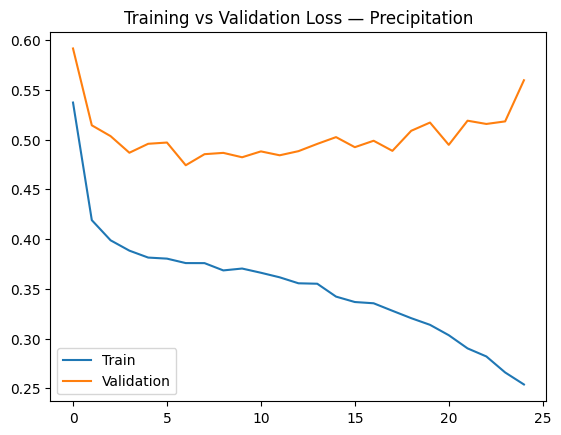

In [16]:
plt.plot(train_losses_p, label='Train')
plt.plot(val_losses_p, label='Validation')
plt.title("Training vs Validation Loss — Precipitation")
plt.legend()
plt.show()


In [17]:
model_prec.eval()
preds_p, actuals_p = [], []

with torch.no_grad():
    for X, y in test_ds_prec:
        X = X.unsqueeze(0).to(device)
        preds_p.append(model_prec(X).item())
        actuals_p.append(y.item())

rmse_p = np.sqrt(mean_squared_error(actuals_p, preds_p))
mae_p = mean_absolute_error(actuals_p, preds_p)

print("Precipitation RMSE:", rmse_p)
print("Precipitation MAE:", mae_p)


Precipitation RMSE: 0.9925076661330609
Precipitation MAE: 0.45486084907038493


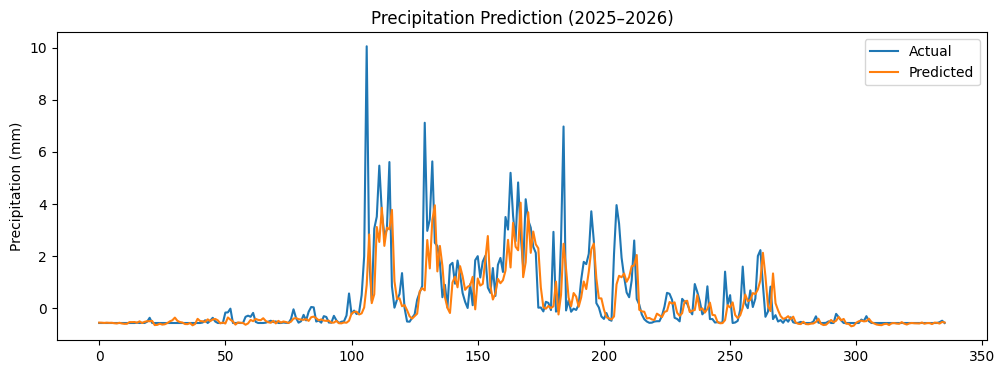

In [18]:
plt.figure(figsize=(12,4))
plt.plot(actuals_p, label='Actual')
plt.plot(preds_p, label='Predicted')
plt.title("Precipitation Prediction (2025–2026)")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()


In [19]:
results = pd.DataFrame({
    'Target': ['Temperature', 'Precipitation'],
    'RMSE': [rmse, rmse_p],
    'MAE': [mae, mae_p]
})

results


,Target,RMSE,MAE
0,Temperature,0.343046,0.264621
1,Precipitation,0.992508,0.454861
